In [36]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
import glob
import datetime
import scipy.io
import numpy as np
import seaborn as sb
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap, cm, addcyclic
% matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import seawater as sw
from ArcticTools import map

In [6]:
mesh=nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc')
e1t= mesh.variables['e1t'][0,400:,:]  # dx
e2t= mesh.variables['e2t'][0,400:,:]  # dy 
e3t= mesh.variables['e3t'][0,:]
tmask= mesh.variables['tmask'][0,:,400:,:]
dep = mesh.variables['gdept_0'][0.,:]

bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

In [7]:
dfield_dx = np.zeros((2,bathy.shape[0],bathy.shape[1]))
dfield_dx.shape

(2, 400, 544)

# Calculate dH

In [8]:
def gradient(Pressure):
    '''    
    ug = -dP_y/(f*rho)
    vg = dP_x/(f*rho)
    This function calculate dP_dx, dP_dy
    '''
    dP = d_(Pressure);
    dx = e1t;
    dy = e2t;
    dP_x = dP[0,:]/dx;
    dP_y = dP[1,:]/dy;
    return dP_x, dP_y

def d_(field):
    '''    
    ug = -dP_y/(f*rho)
    vg = dP_x/(f*rho)
    In order to calculate dP_dx, dP_dy, we need dP. This function does this job.
    '''
    dfield= np.zeros((2,field.shape[0],field.shape[1]))
    # dx
    dfield[0,:, :-1] = field[:, 1:]-field[:, :-1]
    dfield[0,:,-1] = dfield[0,:,-2] # assuming the last two columns have the same dx (and dy)
    # dy
    dfield[1,:-1, :] = field[1:, :]-field[:-1, :]
    dfield[1,-1,:] = dfield[1,-2,:]
    return dfield

In [9]:
# calculate d(H)

dbathy= gradient(bathy)

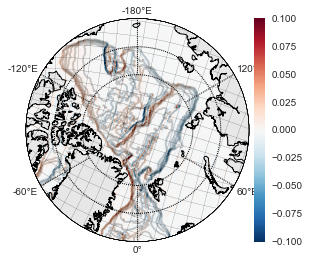

In [10]:
m,x,y = map.mapping(70)
m.pcolor(x,y,dbathy[0],cmap = 'RdBu_r',vmin=-0.1,vmax=0.1)  #dx
m.colorbar()

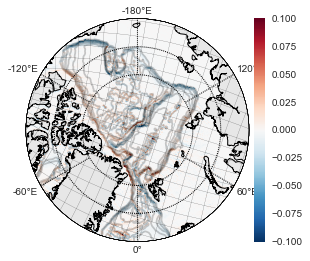

In [11]:
m,x,y = map.mapping(70)
m.pcolor(x,y,dbathy[1],cmap = 'RdBu_r',vmin=-0.1,vmax=0.1) #dy
m.colorbar()

In [12]:
def load_v(vel_comp,T, tmask, ENG, key ):
    '''
    This function is designed to obtain velocity field
    ======================================================
    '''
    vels ={'U':'vozocrtx','V':'vomecrty','W':'vovecrtz'}

    with nc.Dataset(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*%s*%s.nc'%(ENG,vel_comp,T))[0])\
as temp:
        data  = temp.variables[vels[vel_comp]][0,:,400:,:]
        data [tmask == 0] = np.nan
    return data

In [13]:
def calulateT(year,ENG,layer):
    '''Calculate T = (u X (Delta H) in z direction)
    Input:
    year: calender year
    ENG: 'EXH001', EXH005','ENG3'
    layer: NEMO layer
    
    Output:
    result of T
    '''
    # load vel
    u= load_v('U',T=year,tmask= tmask, ENG=ENG, key = 'U')
    v= load_v('V',T=year,tmask= tmask, ENG=ENG, key = 'V')

    # arrange array in order
    totU= np.array((u[layer,:,:],v[layer,:,:]))
    totdH = np.array((dbathy[0],dbathy[1]))

    # allocation
    T = np.zeros_like(u[layer,:,:])

    # calculate cross product
    for i in range (totdH.shape[1]):
        for j in range (totdH.shape[2]):
            T[i,j] = np.float(-totU[1,i,j]*totdH[0,i,j] + totU[0,i,j]*totdH[1,i,j])* e1t[i,j] * e2t[i,j]
    # masked 9 and in valid numbers
    test = np.ma.masked_invalid(np.ma.masked_where(T==0,T))
    return test

In [14]:
dep[35]

1062.4397212448976

# Calculate T = (u X (Delta H) in z direction)

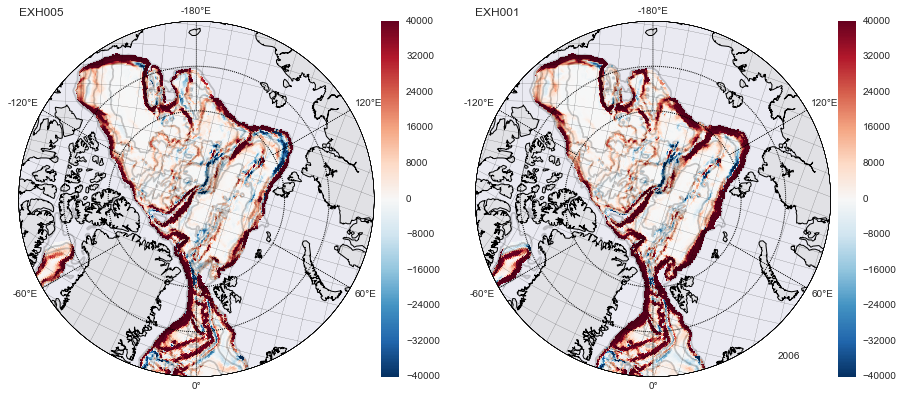

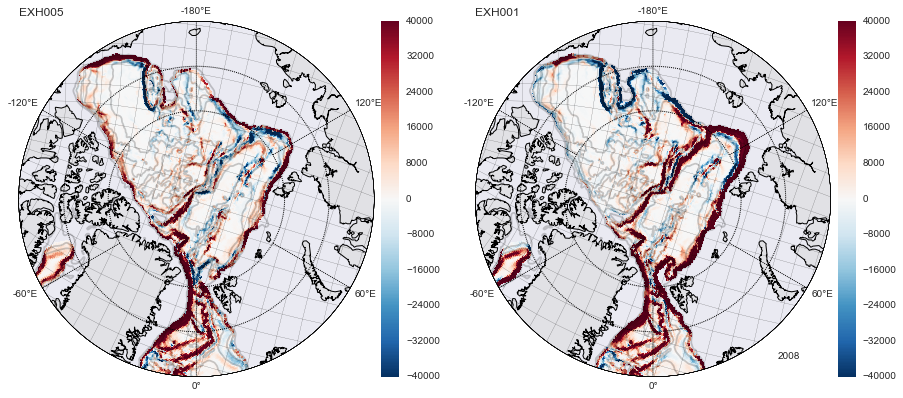

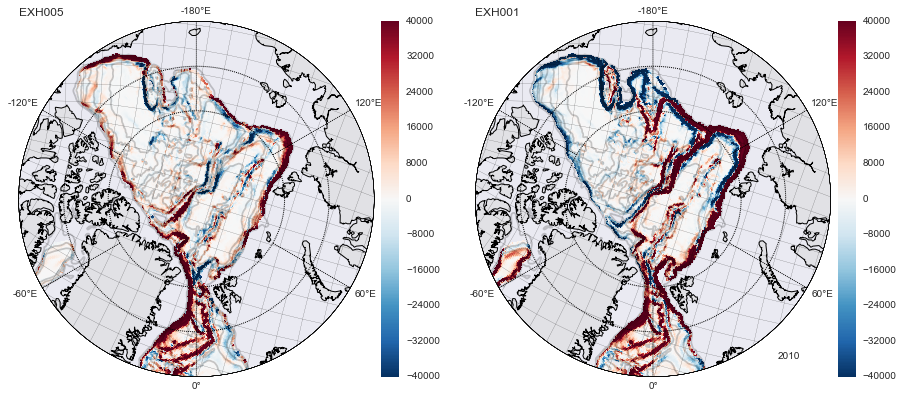

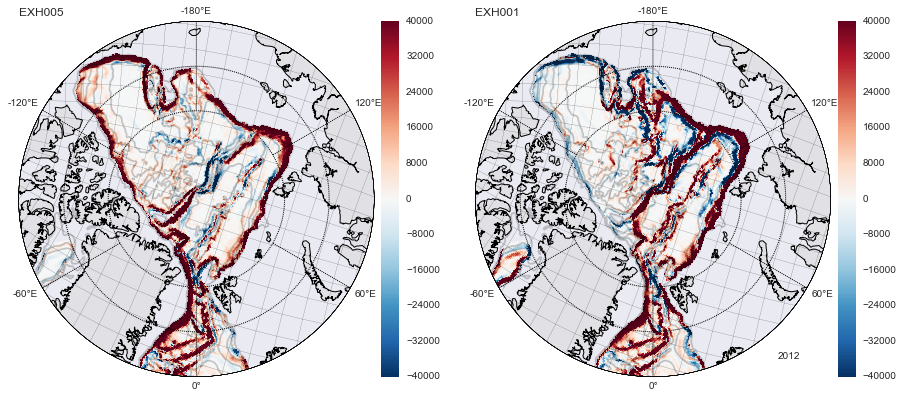

In [15]:
for i in range (2006,2014,2):
    test = calulateT(i,'EXH005',35)
    plt.figure(figsize=(15,10))
    ax=plt.subplot(121)
    m,x,y = map.mapping(70)
    m.pcolor(x,y,test,cmap = 'RdBu_r',vmin=-4e4,vmax=4e4) #dy
    m.colorbar()
    ax.set_title('EXH005',loc='left')
    
    ax = plt.subplot(122)
    test = calulateT(i,'EXH001',35)
    m,x,y = map.mapping(70)
    m.pcolor(x,y,test,cmap = 'RdBu_r',vmin=-4e4,vmax=4e4) #dy
    m.colorbar()
    ax.text(0.85,0.05,i,transform=ax.transAxes)
    ax.set_title('EXH001',loc='left')
    plt.show()

# Sum T in Canada Basin

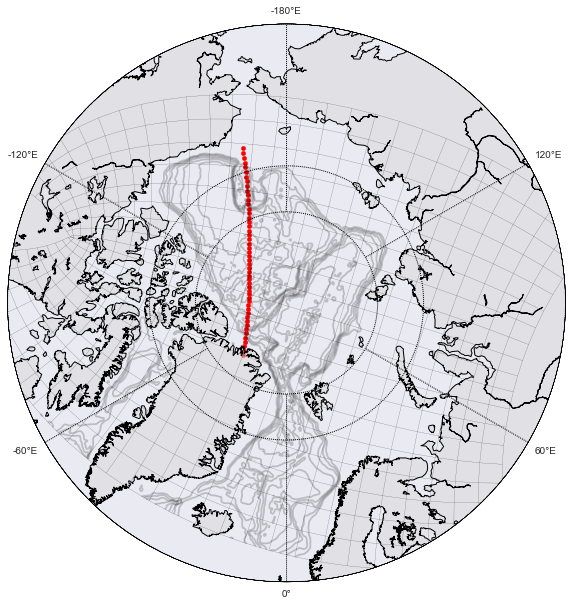

In [16]:
fig = plt.figure(figsize = (10,10))
m,x_lon,y_lat = map.mapping(60)

a= [400-260] 
b= [280]#195]  

for i in range (1,50):
    a.append(a[i-1]+4)
    b.append(b[i-1]-1)
m.scatter(x_lon[a,b],y_lat[a,b],color='r')

In [17]:
mymask = np.zeros_like(e1t[:,:])

for xnum in range (a[0],a[-1]):
    blim = int(-0.25*(xnum-150)+b[0])
    mymask[xnum,:blim] = 1

* test result

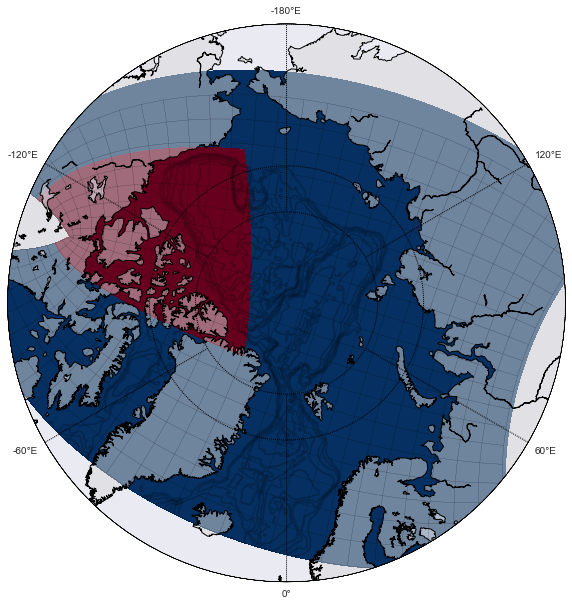

In [18]:
fig = plt.figure(figsize = (10,10))
m,x_lon,y_lat = map.mapping(60)

m.pcolor(x_lon,y_lat,mymask,cmap= 'RdBu_r')

In [19]:
def sumT(year,ENG,layer):
    '''Calculate T = (u X (Delta H) in z direction)
    Input:
    year: calender year
    ENG: 'EXH001', EXH005','ENG3'
    layer: NEMO layer
    
    Output:
    result of T
    '''
    # load vel
    u= load_v('U',T=year,tmask= tmask, ENG=ENG, key = 'U')
    v= load_v('V',T=year,tmask= tmask, ENG=ENG, key = 'V')

    # arrange array in order
    totU= np.array((u[layer,:,:],v[layer,:,:]))
    totdH = np.array((dbathy[0],dbathy[1]))

    # allocation
    T = np.zeros_like(u[layer,:,:])

    # calculate cross product
    for i in range (totdH.shape[1]):
        for j in range (totdH.shape[2]):
            T[i,j] = np.float(-totU[1,i,j]*totdH[0,i,j] + totU[0,i,j]*totdH[1,i,j])* e1t[i,j] * e2t[i,j]
    # masked 9 and in valid numbers
    test = np.ma.masked_invalid(np.ma.masked_where(T==0,T))
    test = np.sum(test*mymask)
    
    return test

* time series for sum T

In [20]:
Tsum=[]
time=[]
for i in range (2002,2014):
    test = sumT(i,'EXH001',35)
    Tsum.append(test)
    time.append(i)

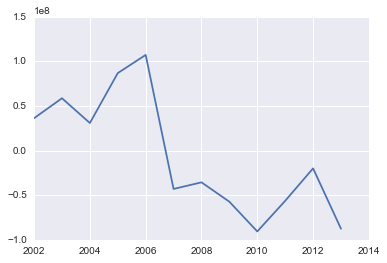

In [21]:
plt.plot(time,Tsum)

# location for calculating TPD

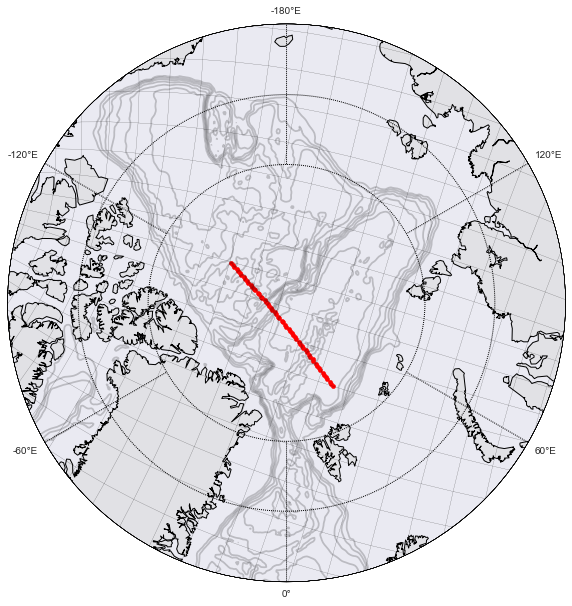

In [22]:
fig = plt.figure(figsize = (10,10))
m,x_lon,y_lat = map.mapping(70)

#a= [-260] 2
#b= [260]  1
aLR=[-240]
bLR=[350]
for i in range (1,60):
    aLR.append(aLR[i-1]+1)
    bLR.append(bLR[i-1]-1.5)
m.scatter(x_lon[aLR,bLR],y_lat[aLR,bLR],color='r')

* EXH001

In [23]:
FluxEXH001=[]
layer= 24
for year in range (2002,2014):
    v= load_v('V',T=year,tmask= tmask, ENG='EXH001', key = 'V')
    u= load_v('U',T=year,tmask= tmask, ENG='EXH001', key = 'U')
    
    z= 1.5**2+1**2
    
    totv = v * 1/z+ u * 1.5/z 
    dsec  = ((e2t * 1)**2 + (e1t * 1.5)**2)**0.5
    flux = 0
    for num in range(layer):
        flux += totv[num,aLR,bLR] * dsec[aLR,bLR] *e3t[num,aLR,bLR]
    flux[flux > 0] = np.nan
    FluxEXH001.append(flux)


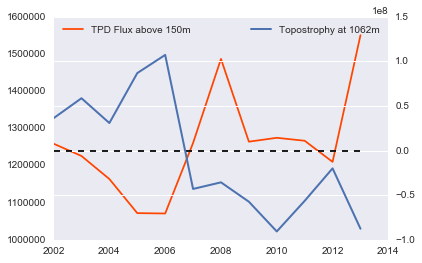

In [24]:
# plot
fig, ax1 = plt.subplots()
ax1.plot(time,-np.nansum(np.array(FluxEXH001),axis=1),c='orangered',label='TPD Flux above 150m') 
ax1.legend(loc=2)
ax1.grid(False)

ax2 = ax1.twinx()        
ax2.plot(time,Tsum,lw=2,label='Topostrophy at %sm'%int(dep[35]))
ax2.hlines(y=0,xmin=np.min(time),xmax=np.max(time),linestyles='--')
ax2.legend()

In [25]:
Tsum500=[]
for i in range (2002,2014):
    test = sumT(i,'EXH001',30)
    Tsum500.append(test)

In [26]:
Tsum150=[]
for i in range (2002,2014):
    test = sumT(i,'EXH001',24)
    Tsum150.append(test)

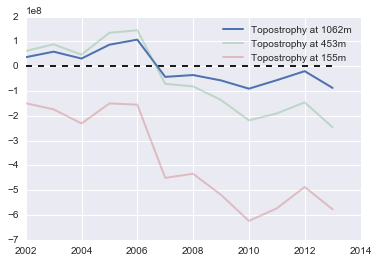

In [27]:
fig = plt.figure()  
plt.plot(time,Tsum,lw=2,label='Topostrophy at %sm'%int(dep[35]))
plt.plot(time,Tsum500,lw=2,label='Topostrophy at %sm'%int(dep[30]),alpha=0.3)
plt.plot(time,Tsum150,lw=2,label='Topostrophy at %sm'%int(dep[24]),alpha=0.3)
plt.hlines(y=0,xmin=np.min(time),xmax=np.max(time),linestyles='--')
plt.legend()

* EXH005

In [28]:
Flux=[]
layer= 24
for year in range (2002,2014):
    v= load_v('V',T=year,tmask= tmask, ENG='EXH005', key = 'V')
    u= load_v('U',T=year,tmask= tmask, ENG='EXH005', key = 'U')
    
    z= 1.5**2+1**2
    
    totv = v * 1/z+ u * 1.5/z 
    dsec  = ((e2t * 1)**2 + (e1t * 1.5)**2)**0.5
    flux = 0
    for num in range(layer):
        flux += totv[num,aLR,bLR] * dsec[aLR,bLR] *e3t[num,aLR,bLR]
    flux[flux > 0] = np.nan
    Flux.append(flux)


In [29]:
Tsum500=[]
for i in range (2002,2014):
    test = sumT(i,'EXH005',30)
    Tsum500.append(test)

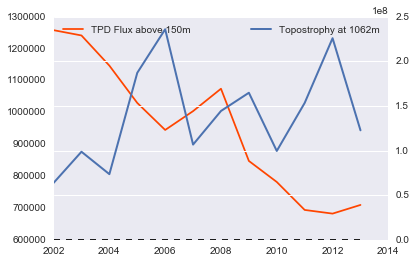

In [30]:
# plot
fig, ax1 = plt.subplots()
ax1.plot(time,-np.nansum(np.array(Flux),axis=1),c='orangered',label='TPD Flux above 150m') 
ax1.legend(loc=2)
ax1.grid(False)

ax2 = ax1.twinx()        
ax2.plot(time,Tsum500,lw=2,label='Topostrophy at %sm'%int(dep[35]))
ax2.hlines(y=0,xmin=np.min(time),xmax=np.max(time),linestyles='--')
ax2.legend()

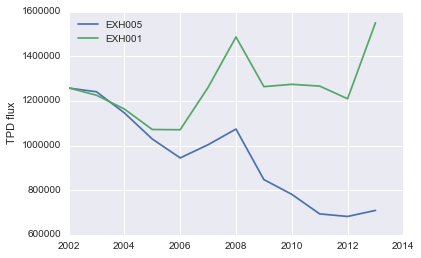

In [35]:
fig, ax1 = plt.subplots()
ax1.plot(time,-np.nansum(np.array(Flux),axis=1),label='EXH005') 
ax1.plot(time,-np.nansum(np.array(FluxEXH001),axis=1),label='EXH001') 
ax1.set_ylabel('TPD flux')
ax1.legend(loc=0)